In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from time import time
from scipy import stats
from apyori import apriori
from collections import Counter
from itertools import combinations


In [2]:
aisle = pd.read_csv("aisles.csv")
aisle.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [3]:
departments = pd.read_csv("departments.csv")
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [4]:
orders = pd.read_csv("orders.csv")
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
products = pd.read_csv("products.csv")
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
order_products_train = pd.read_csv("order_products__train.csv")
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## 1. MAIN goal is to predict which products will be in a user's next order
- We have User's prior orders, So we want to predict which products will the user reorder by looking at his prior orders

### Create data frame with latest purchase


In [8]:
order_products_pr = pd.merge(order_products_prior, orders, how="inner", on="order_id")

In [9]:
# get the products and reorder status of the latest purchase of each user #
prior_grouped_df = order_products_pr.groupby("user_id")["order_number"].aggregate("max").reset_index()
prior_df_latest = pd.merge(order_products_pr, prior_grouped_df, how="inner", on=["user_id", "order_number"])
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]
prior_df_latest.head()

,user_id,product_id,reordered_latest
0,59897,9755,1
1,59897,31487,0
2,59897,37510,1
3,59897,14576,1
4,59897,22105,0


### Get count of Number of reorders

In [10]:
# get the count of each product and number of reorders by the customer #
prior_df_agg = order_products_pr.groupby(["user_id","product_id"])["reordered"].aggregate(["count", "sum"]).reset_index()
prior_df_agg.columns = ["user_id", "product_id", "reordered_count", "reordered_sum"]
prior_df_agg.head()

,user_id,product_id,reordered_count,reordered_sum
0,1,196,10,9
1,1,10258,9,8
2,1,10326,1,0
3,1,12427,10,9
4,1,13032,3,2


### merge the "prior_df_latest" df with "prior_df_agg"

In [11]:
prior_df_merge = pd.merge(prior_df_agg, prior_df_latest, how="left", on=["user_id","product_id"])
prior_df_merge.head()

,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,196,10,9,1.0
1,1,10258,9,8,1.0
2,1,10326,1,0,NaN
3,1,12427,10,9,1.0
4,1,13032,3,2,1.0


### Read the train and test dataset and then merge with orders data to get the user_id for the corresponding order_id.



In [12]:
orders = orders.drop(["order_number"],axis=1)

train_df = pd.read_csv("order_products__train.csv", usecols=["order_id"])

train_df.head()

,order_id
0,1
1,1
2,1
3,1
4,1


### Get distinct order id in train_df. This will help in joining the data frame with orders

In [13]:
train_df = train_df.groupby("order_id").aggregate("count").reset_index()
train_df.head()

,order_id
0,1
1,36
2,38
3,96
4,98


### Join with Orders data frame

In [14]:
train_df = pd.merge(train_df, orders, how="inner", on="order_id")

train_df = train_df.loc[:,["order_id", "user_id"]]
train_df.head()


,order_id,user_id
0,1,112108
1,36,79431
2,38,42756
3,96,17227
4,98,56463


In [15]:
test_df = pd.read_csv("sample_submission.csv", usecols=["order_id"])
test_df = pd.merge(test_df, orders, how="inner", on="order_id")
test_df = test_df.loc[:,["order_id", "user_id"]]
test_df.head()

,order_id,user_id
0,17,36855
1,34,35220
2,137,187107
3,182,115892
4,257,35581


### Merge the train and test data with prior_df to get the products purchased previously by the customer.

In [16]:
train_df = pd.merge(train_df, prior_df_merge, how="inner", on="user_id")
train_df.head()


,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,112108,2067,1,0,NaN
1,1,112108,5707,2,1,1.0
2,1,112108,11109,2,1,NaN
3,1,112108,14947,3,2,1.0
4,1,112108,22035,2,1,NaN


In [17]:
test_df = pd.merge(test_df, prior_df_merge, how="inner", on="user_id")
test_df.head()


,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,17,36855,1283,1,0,NaN
1,17,36855,6291,1,0,NaN
2,17,36855,7035,1,0,NaN
3,17,36855,11494,1,0,NaN
4,17,36855,13107,3,2,1.0


In [18]:
products = pd.read_csv("products.csv", usecols=["product_id", "aisle_id", "department_id"])

products.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


In [19]:
train_df = pd.merge(train_df, products, how="inner", on="product_id")
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,NaN,3,19
1,96,17227,2067,1,0,NaN,3,19
2,3243,206024,2067,1,0,NaN,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,NaN,3,19


In [20]:
test_df = pd.merge(test_df, products, how="inner", on="product_id")
test_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,17,36855,1283,1,0,NaN,100,21
1,657743,16994,1283,1,0,NaN,100,21
2,834223,92628,1283,1,0,NaN,100,21
3,1446886,75870,1283,1,0,NaN,100,21
4,1518981,118458,1283,3,2,NaN,100,21


In [21]:
train_y_df = pd.read_csv("order_products__train.csv", usecols=["order_id", "product_id", "reordered"])

train_y_df.head()

,order_id,product_id,reordered
0,1,49302,1
1,1,11109,1
2,1,10246,0
3,1,49683,0
4,1,43633,1


In [22]:
train_y_df = pd.merge(train_y_df, orders, how="inner", on="order_id")
train_y_df = train_y_df[["user_id", "product_id", "reordered"]]
train_df = pd.merge(train_df, train_y_df, how="left", on=["user_id", "product_id"])
train_df["reordered"].fillna(0, inplace=True)
print(train_df.shape)

(8474661, 9)


In [23]:
from numpy import loadtxt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [24]:
tr_data = train_df #i did this step so that I have the independence to do this -> tr_data = train_df.iloc[:10000,:]
print("shape of new train data: ",tr_data.shape)
X=tr_data.drop('reordered',axis=1)
X.head()

shape of new train data:  (8474661, 9)


,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,NaN,3,19
1,96,17227,2067,1,0,NaN,3,19
2,3243,206024,2067,1,0,NaN,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,NaN,3,19


In [25]:
Y = tr_data['reordered']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [27]:
X_train['reordered_latest'] = X_train['reordered_latest'].replace(np.nan, 0)
X_test['reordered_latest'] = X_test['reordered_latest'].replace(np.nan, 0)

<ipython-input-27-afba85995868>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['reordered_latest'] = X_train['reordered_latest'].replace(np.nan, 0)
<ipython-input-27-afba85995868>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['reordered_latest'] = X_test['reordered_latest'].replace(np.nan, 0)


In [29]:
from sklearn.linear_model import LogisticRegression
#Logistic Regression model
clf=(LogisticRegression(C=0.02))

#fitting the model
clf.fit(X_train, y_train)


#predictions
pred=clf.predict(X_test)

#accuracy score of Logistic Regression Model
print("Accuracy using logistic regression:",accuracy_score(pred, y_test))

Accuracy using logistic regression: 0.9019834165224757


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

clfrf = RandomForestClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000, oob_score=True)

clfrf.fit(X_train, y_train)

#predictions
predrf = clfrf.predict(X_test)


#accuracy score for the random forest model
print("Accuracy using randomforest classifier: ",accuracy_score(predrf, y_test))


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


Accuracy using randomforest classifier:  0.9045404144045763


In [12]:
import lightgbm as lgb

train_X = lgb.Dataset(X_train)
train_y = lgb.Dataset(y_train)
test_X = lgb.Dataset(X_test)
test_y = lgb.Dataset(y_test)

model= lgb.LGBMClassifier()

model.fit(X_train, y_train)
pred=model.predict(X_test)

#accuracy score of Light GBM
print("Accuracy using lightGBM: ",accuracy_score(pred, y_test))


0.9047006066925334


In [31]:
import xgboost as xgb
from xgboost import XGBClassifier


model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy using XGBoost accuracy: ",accuracy)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:39:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy using XGBoost accuracy:  0.9047327881789534


## 2. We would like to know how often the user orders a product on a particular hour of the day.

In [32]:
order_products = pd.concat([order_products_prior, order_products_train])

order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [33]:
orders = pd.read_csv("orders.csv")

orders_test = orders[orders['eval_set'] == 'test']

In [34]:
df = pd.merge(orders, order_products, on='order_id')
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [35]:
products = pd.read_csv("products.csv")

combined_data = pd.merge(df, products, on='product_id')
combined_data = pd.merge(combined_data, aisle, on='aisle_id')
combined_data = pd.merge(combined_data, departments, on='department_id')
combined_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,soft drinks,beverages
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,soft drinks,beverages
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,soft drinks,beverages
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,soft drinks,beverages


Create a MultiIndex for the combined DataFrame: ('user_id', 'order_number', 'add_to_cart_order') uniquely specifies rows.


'days_since_prior_order' is NaN when 'order_number' is 1 because thats the user's first order and there is no prior order before it.

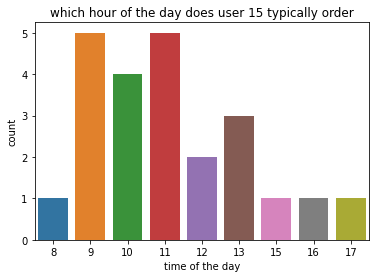

In [36]:
user_order_hour = []
for i in range(len(orders["user_id"])):
    if orders["user_id"][i] == 15:
        user_order_hour.append(orders["order_hour_of_day"][i])
    else:
        pass
    
plt.title("which hour of the day does user 15 typically order")
      
sns.countplot(x=user_order_hour)
plt.xlabel("time of the day")
plt.show()

- As we can see from the above plot, user 15 typically orders at 9AM and 11AM, so instacart can look load all his recommendations during this time.
- This also helps us build a persona about user behavior which is very important for market basket analysis.


### Also we want to find out which product is the most reordered and which product is the least reordered

In [37]:

reorder_aisle = combined_data.groupby(['aisle', 'department'])['reordered'].mean().to_frame().reset_index()

reorder_aisle.sort_values('reordered', ascending=False)[:5]\
.append(pd.Series('...', index=reorder_aisle.columns), ignore_index=True)\
.append(reorder_aisle.sort_values('reordered', ascending=False)[-5:], ignore_index=True)

,aisle,department,reordered
0,milk,dairy eggs,0.781812
1,water seltzer sparkling water,beverages,0.72993
2,fresh fruits,produce,0.718823
3,eggs,dairy eggs,0.706359
4,soy lactosefree,dairy eggs,0.692361
5,...,...,...
6,beauty,personal care,0.212858
7,first aid,personal care,0.195864
8,kitchen supplies,household,0.194802
9,baking supplies decor,pantry,0.167595


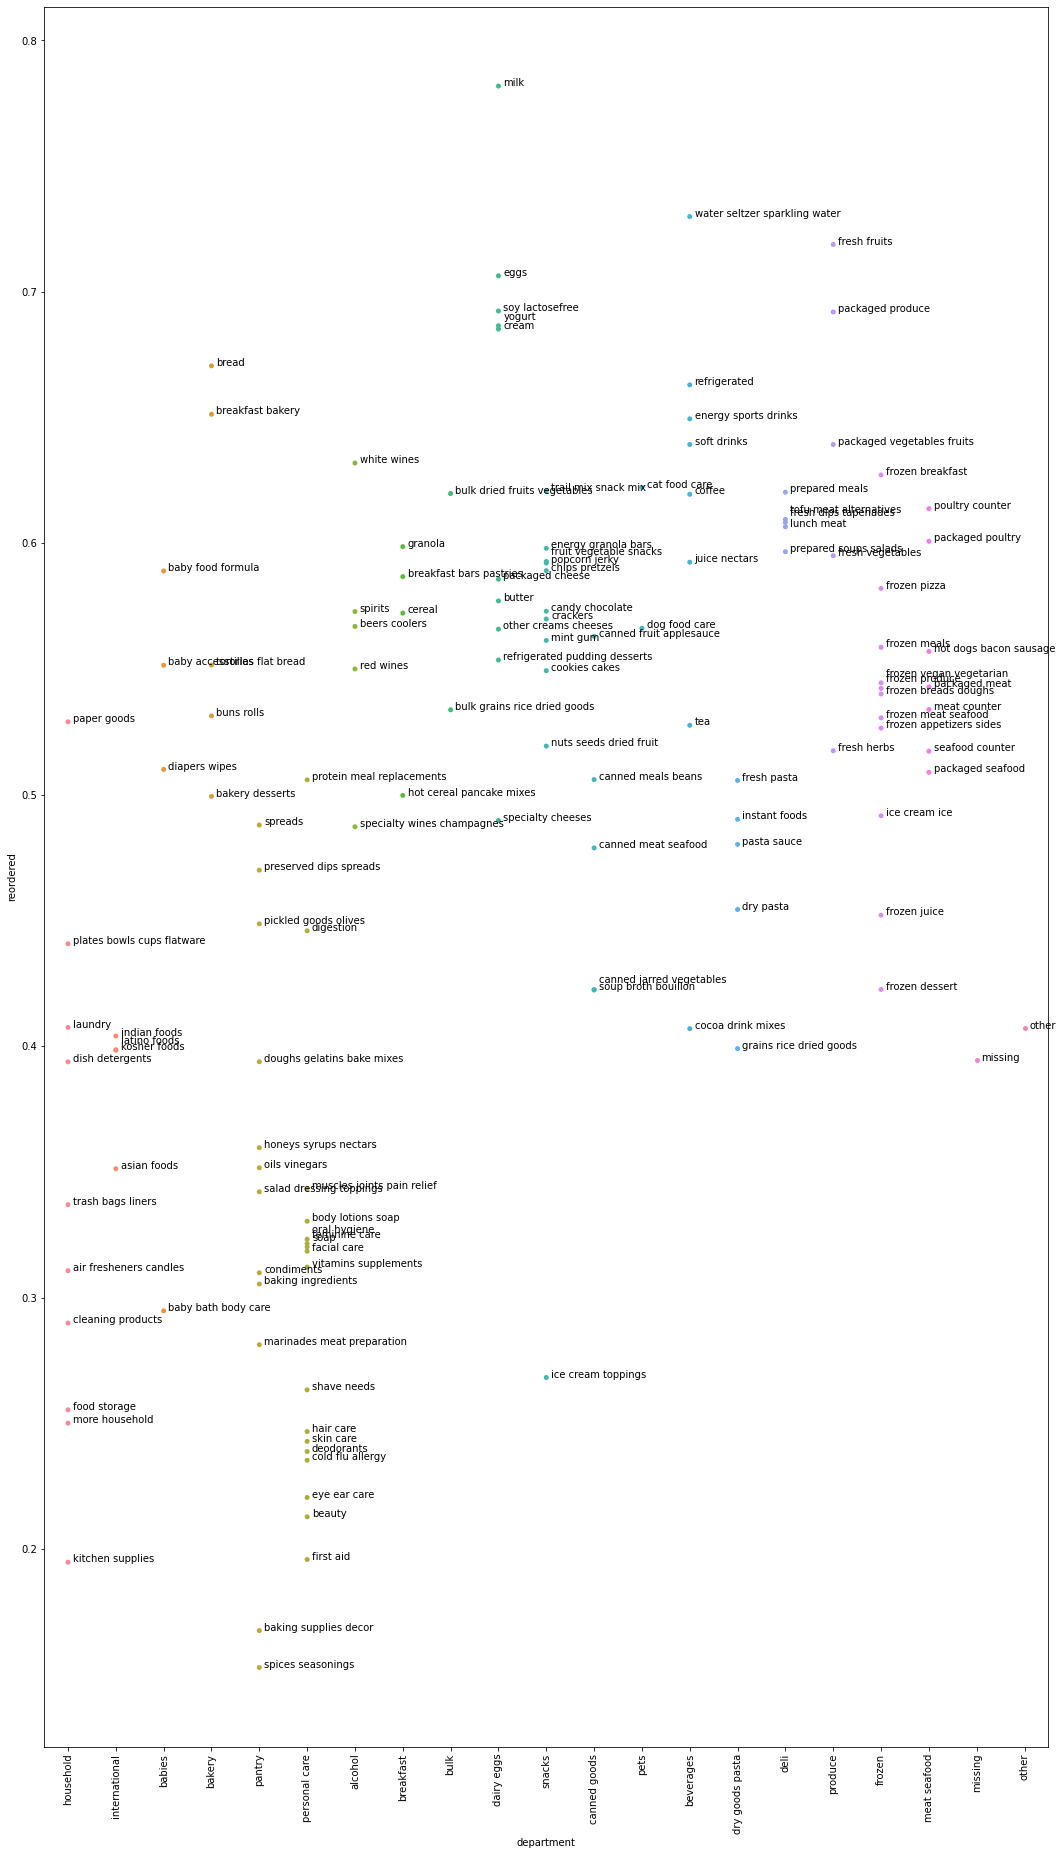

In [38]:

plt.figure(figsize=(18,32))

ax = sns.stripplot(x='department', y='reordered', data=reorder_aisle, jitter=False)

plt.xticks(rotation='vertical')

# Make a list of all department names with the same ordinal values as seaborn plot
dep_cat = reorder_aisle['department'].unique().tolist()

# Annotate with aisle names
for i in range(reorder_aisle.shape[0]):
    # Add some distance for overlapping annotations in the same category. More work necessary for multiple overlapping annotations.
    if (reorder_aisle[reorder_aisle['department'] == reorder_aisle['department'].iloc[i]]['reordered'] \
        - reorder_aisle['reordered'].iloc[i]).between(-0.0025, 0, inclusive=False).any(): 
        ax.annotate(reorder_aisle['aisle'].iloc[i],
                    xy=(dep_cat.index(reorder_aisle['department'].iloc[i]), reorder_aisle['reordered'].iloc[i]),
                    xytext=(dep_cat.index(reorder_aisle['department'].iloc[i])+0.1, reorder_aisle['reordered'].iloc[i]+0.0025))
    else:
        ax.annotate(reorder_aisle['aisle'].iloc[i],
                    xy=(dep_cat.index(reorder_aisle['department'].iloc[i]), reorder_aisle['reordered'].iloc[i]),
                    xytext=(dep_cat.index(reorder_aisle['department'].iloc[i])+0.1, reorder_aisle['reordered'].iloc[i]))

plt.show()

As we can see from the above table and from the above graph,
- Milk is the most reordered product, it makes sense as milk expires quickly
- Spices is the less reordered product, This too makes sense as spices seasongings have a longer expiry date

## 3. we wanted to build a association model, which would tell how products are associated using Association rule mining.
- This type of analysis would help instacart streamline their supply chain by storing associated items together in the warehouses for faster delivery.


## Association Rules Mining:
Given that we are only looking at item sets of size 2, the association rules we will generate will be of the form
{A} -> {B}. One common application of these rules is in the domain of recommender systems, where customers who purchased item A are recommended item B.


### support
- This is the percentage of orders that contains the item set. 
- example: if there are 5 orders in total and {apple,egg} occurs in 3 of them, so:
- support{apple,egg} = 3/5 or 60%
(The minimum support threshold required by apriori can be set based on knowledge of your domain - Hyperparameter)

### confidence
- Given two items, A and B, confidence measures the percentage of times that item B is purchased, given that item A was purchased. This is expressed as:
- confidence{A->B} = support{A,B} / support{A}
- Confidence values range from 0 to 1, where 0 indicates that B is never purchased when A is purchased, and 1 indicates that B is always purchased whenever A is purchased
- We can think of it as conditional probability
- from our above example, confidence{apple->egg} = support{apple,egg} / support{apple} = (3/5) / (4/5) = 0.75 or 75%

### lift
- Given two items, A and B, lift indicates whether there is a relationship between A and B, or whether the two items are occuring together in the same orders simply by chance (ie: at random). 
- Unlike the confidence metric whose value may vary depending on direction (eg: confidence{A->B} may be different from confidence{B->A}), lift has no direction. This means that the lift{A,B} is always equal to the lift{B,A}
- lift{A,B} = lift{B,A} = support{A,B} / (support{A} * support{B})
- From our above example, lift{apple,egg} = lift{egg,apple} = support{apple,egg} / (support{apple} * support{egg}) = (3/5) / (4/5 * 3/5) = 1.25

#### lift conditions:
- lift = 1 implies no relationship between A and B. (ie: A and B occur together only by chance)
- lift > 1 implies that there is a positive relationship between A and B. (ie: A and B occur together more often than random)
- lift < 1 implies that there is a negative relationship between A and B. (ie: A and B occur together less often than random)
- you can think of lift as a concept similar correlation factor. But keep in mind lift NOT equal to correlation

Lift is a nice concept of data science, it is basically by how much We are moving up the “percentage chances of a desired outcome”.

lift example: The probability of a person winning a 3 person race is 33.3%, Now if one person drops out, the probability of same person winning is 50%, so the percentage chacnes of a desired outcome has increased

Apriori is an algorithm for frequent item set mining and association rule learning over relational databases. It proceeds by identifying the frequent individual items in the database and extending them to larger and larger item sets as long as those item sets appear sufficiently often in the database.


In [39]:
products_id_to_name = {k: v for k, v in zip(products.product_id, products.product_name)}


In [40]:
def association_rules(order_products, min_support, min_length = 2, max_length = 5, min_confidence = 0.2, min_lift = 1.0):
    
    print('Loading data...')
    transactions_df = order_products[['order_id', 'product_id']]

    print('Calculating product supports...')
    n_orders = len(set(transactions_df.order_id))
    product_frequency = transactions_df.product_id.value_counts()/n_orders
    products_apriori = product_frequency[product_frequency >= min_support]
    transactions_apriori = transactions_df[transactions_df.product_id.isin(products_apriori.index)]
    
    order_sizes = transactions_apriori.order_id.value_counts()
    orders_apriori = order_sizes[order_sizes >= min_length]
    transactions_apriori = transactions_apriori[transactions_apriori.order_id.isin(orders_apriori.index)]
    
    print('Calculating product combinations and supports...')
    
    def product_combinations(transactions_df, max_length = max_length):
        transactions_by_order = transactions_df.groupby('order_id')['product_id']
        max_length_reference = max_length
        for order_id, order_list in transactions_by_order:
            max_length = min(max_length_reference, len(order_list))
            order_list = sorted(order_list)
            for l in range(2, max_length + 1):
                product_combinations = combinations(order_list, l)
                for combination in product_combinations:
                    yield combination
   
    combs = product_combinations(transactions_apriori)
    counter = Counter(combs).items()
    combinations_count = pd.Series([x[1] for x in counter], index = [x[0] for x in counter])
    combinations_frequency = combinations_count/n_orders
    combinations_apriori = combinations_frequency[combinations_frequency >= min_support]
    combinations_apriori = combinations_apriori[combinations_apriori.index.map(len) >= min_length]
    
    print('Populating dataframe...')
    A = []
    B = []
    AB = []
    for c in combinations_apriori.index:
        c_length = len(c)
        for l in range(1, c_length):
            comb = combinations(c, l)
            for a in comb:
                AB.append(c)
                b = list(c)
                for e in a:
                    b.remove(e)
                b = tuple(b)
                if len(a) == 1:
                    a = a[0]
                A.append(a)
                if len(b) == 1:
                    b = b[0]
                B.append(b)
            
    apriori_df = pd.DataFrame({'A': A,
                               'B': B,
                               'AB': AB})
    support = {**{k: v for k, v in products_apriori.items()}, 
               **{k: v for k, v in combinations_frequency.items()}}
    apriori_df[['support_A', 'support_B', 'support_AB']] = apriori_df[['A', 'B', 'AB']].applymap(lambda x: support[x])
    apriori_df.drop('AB', axis = 1, inplace = True)
    apriori_df['confidence'] = apriori_df.support_AB/apriori_df.support_A
    apriori_df['lift'] = apriori_df.confidence / apriori_df.support_B
    apriori_df = apriori_df[apriori_df.confidence >= min_confidence]
    apriori_df = apriori_df[apriori_df.lift >= min_lift]
    apriori_df = apriori_df.sort_values(by = 'lift', ascending = False).reset_index(drop = True)
    
    def convert_product_id_to_name(product_ids):
        if type(product_ids) == int:
            return products_id_to_name[product_ids]
        names = []
        for prod in product_ids:
            name = products_id_to_name[prod]
            names.append(name)
        names = tuple(names)
        return names
    
    apriori_df[['A', 'B']] = apriori_df[['A', 'B']].applymap(convert_product_id_to_name)

    print('{} rules were generated'.format(len(apriori_df)))

    return apriori_df

In [41]:
order_products = order_products_prior.iloc[:10000,:] #taking top 10k products because of memory constraint
rules = association_rules(order_products, min_support = 0.005, max_length = 4)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
143 rules were generated


In [42]:
rules

,A,B,support_A,support_B,support_AB,confidence,lift
0,Non Fat Black Cherry on the Bottom Greek Yogurt,Peach on the Bottom Nonfat Greek Yogurt,0.005118,0.010235,0.005118,1.000000,97.700000
1,Peach on the Bottom Nonfat Greek Yogurt,Non Fat Black Cherry on the Bottom Greek Yogurt,0.010235,0.005118,0.005118,0.500000,97.700000
2,Blackberries,Raspberries,0.011259,0.026612,0.005118,0.454545,17.080420
3,Organic Reduced Fat 2% Milk,Half & Half,0.017400,0.018424,0.005118,0.294118,15.964052
4,Half & Half,Organic Reduced Fat 2% Milk,0.018424,0.017400,0.005118,0.277778,15.964052
...,...,...,...,...,...,...,...
138,Raspberries,Banana,0.026612,0.159672,0.006141,0.230769,1.445266
139,Organic Grape Tomatoes,Banana,0.023541,0.159672,0.005118,0.217391,1.361483
140,Asparagus,Banana,0.024565,0.159672,0.005118,0.208333,1.304754
141,Organic Raspberries,Banana,0.039918,0.159672,0.008188,0.205128,1.284681
